<a href="https://colab.research.google.com/github/pikey-msc/DeepLearn/blob/master/Notebooks/Reuso_de_redes_preentrenadas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transferencia del conocimiento (Knowledge Transfering)

Basado en el ejemplo 5.3 de F Chollet, Deep Learning with Python, Ed Manning, 2018

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1";  

In [ ]:
import keras
keras.__version__

#VGG16: Una Red Convolucional Preentrenada
Una estrategia para lidiar en redes neuronales profundas es usar redes previamente preentrenadas con bases de datos grandes y adaptarlas al problema de nuestro interés.

Para este propósito es necesario que la red preentrenada haya sido entrenada para resolver un problema de carácter mas general, del que nuestro problema se pueda consider un caso particular. Por ejemplo, para el caso de clasificar perros y gatos podemos usar una red entrenada para clasificar mas clases como la llamada VGG16 (Simonyan and Zisserman, 2015). Las razones que por la que usamos VGG16 son las siguientes

* Tiene una arquitectura fácil de comprender y, en su caso, de implementar.

* Logra un excelente resultado en la competencia ImageNet (ILSVRC-2014), entre el 96% y 97%.

* Contienen relativamente pocas capas convolucionales: 13 capas convolucionales y 3 densas, de ahí que en sus nombre incluya el 16.

* La red (modelo y pesos entrenados) esta diponible en Kera

(Simonyan and Zisserman, 2015) K. Simonyan and A. Zisserman, Very Deep Convolutional Networks for Large-Scale Image Recognition, 3rd ICLR 2015.

Las redes diponibles en keras que fueron entrenadas en la BD ImageNet son

* Xception
* InceptionV3
* ResNet50
* VGG16
* VGG19
* MobileNet

La red VGG19 es una variante con mas capas de cálculo que la VGG16, por lo tanto mas pesada de almacenar en memoria y en requerimientos de cómputo.

Como vemos, dado que VGG16 fue entrenada para resolver el problema de clasificación de 1000 clases en ImageNet, debe en sus pesos codificar información para extraer rasgos de muy distintas classes de representradas en las mas de 1.4 millones de fotografías de ImageNet. Entre esas clases hay muy distintas variedades de animales, en muy distintos entornos. Por ello, VGG16 es una muy buena candidata para ser particularizada al problema de clasificación binario de perros y gatos.

Notamos que hay aquitecturas mas modernas, con mejores desempeños, pero VGG16 servirá muy bien para nuestro propósito. Como vimos en los ejemplos anteriores, las redes convolucionales para clasificación siguen una estructura de dos bloques:

1. Etapa de capas convolucionales para extracción de rasgos

2. Etapa de decisión basada en capas densas.

VGG16 sigue fielmente esta arquitectura. Ver la siguiente figura

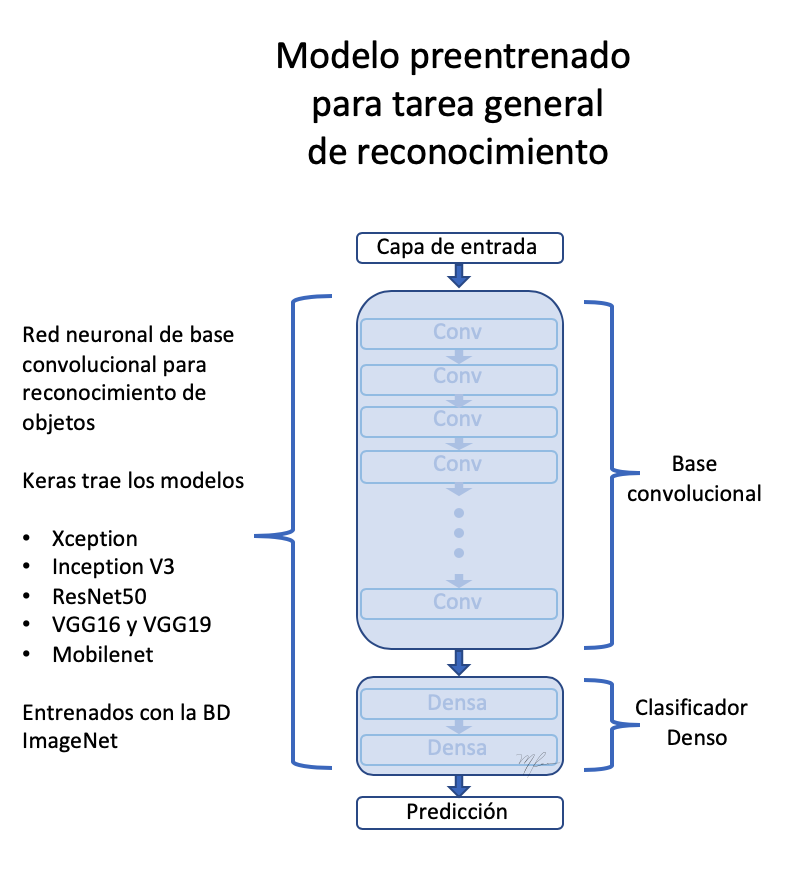

El usar la VGG16 entrenada previamente con la BD ImageNet nos permite asumir que su etapa de extración de rasgos codifica, efectivamente, las relaciones epaciales que hacen a los objetos distinguibles y por la bastedad de ImageNet, nos hace asumir que dichas relaciones espaciales son los suficientemente genéricas para poder codificar rasgos distintivos de perros y gatos.

Iremos paso a paso, primero cargamos la red VGG16 dentro del paquete ``keras.applications``.

## Acceso a los Componentes de una Red Convolucional Preentrenada
Veamos como cargar un modelo preentrenado y como podemos tener acceso a sus componentes. A manera de ilustración definimos nuestra versión de la función ``summary`` de los modelos de keras. Con ello mostramos como acceder a los nombres de las capas, sus número de parametros, etc.

In [ ]:
def resumen(model=None):
    '''
    '''
    header = '{:4} {:16} {:24} {:24} {:10}'.format('#', 'Layer Name','Layer Input Shape','Layer Output Shape','Parameters'
    )
    print('='*(len(header)))
    print(header)
    print('='*(len(header)))
    count=0
    count_trainable=0
    for i, layer in enumerate(model.layers):
        count_trainable += layer.count_params() if layer.trainable else 0
        input_shape = '{}'.format(layer.input_shape)
        output_shape = '{}'.format(layer.output_shape)
        str = '{:<4d} {:16} {:24} {:24} {:10}'.format(i,layer.name, input_shape, output_shape, layer.count_params())
        print(str)
        count += layer.count_params()
    print('_'*(len(header)))
    print('Total Parameters : ', count)
    print('Total Trainable Parameters : ', count_trainable)
    print('Total No-Trainable Parameters : ', count-count_trainable)
    
  
vgg16=None

Luego cargamos el modelo VGG16 con los siguientes parámetros:

* **weights** indica que pesos serán los usados para inicializar el modelo

* **include_top** indica si se carga la red completa (extracción de características y etapa de decisión) o solo la etapa de extración de resgos

* **input_shape** la forma de las imágenes a procesar (opcional, dado que la red pueded procesar cualquier dimensión de imágenes)

In [ ]:
from keras.applications import VGG16

vgg16 = VGG16(weights='imagenet',
                  include_top=True,
                  input_shape=(224, 224, 3))

resumen(vgg16)

Son cerca de 139 millones de parámetros. Realmente consumió tiempo decargar el modelo completo (se realiza solo para primera vez que se invoca la función VGG16. Notamos que, afortunadamente, muchos de los parámetros (como el 90%) corresponden a la etapa de decisión. La etapa de extracción de rasgos (ilustrada en la siguiente figura) tiene menos parámetros.

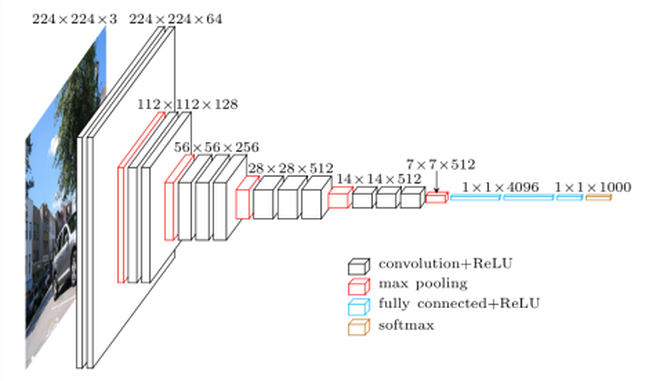

Para evitar cargar capas que no usaremos podemos invocar el método con el parámetro ``include_top=False`` y para el tamañno específico que hemos usado ($150 \times 150$ pixeles)

In [ ]:
if vgg16 != None:
    del vgg16
    
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))
    
resumen(conv_base)    

Son “solamente” poco menos de 15 millones de parámetros, una reducción sustancial respecto a la red VGG16 completa.

Veamos el resumen de la red de Keras

In [ ]:
conv_base.summary()

La salida final del modelo base cargado (``conv_base``) tienen la forma ``(4, 4, 512)``.

##Red Preentrenada como Extractor Rasgos Fuera de Línea
La primera estrategia que usaremos para reusar el conocimiento almacenado (adquirido) por una red clasificadora y particularizarlo a nuestro será en el considerar la extracción de rasgos independiente de la clasificación. Es un enfoque del tipo somero (en contraposición con lo profundo). Esto es, pasaremos las imágenes a la red convolucional base (``conv_base``) y almacenaremos en memoria o disco las características (lo que es computacionalmente eficiente) para luego alimentar con dichos rasgos un clasificador. Esto se ilustra en la siguiente figura.

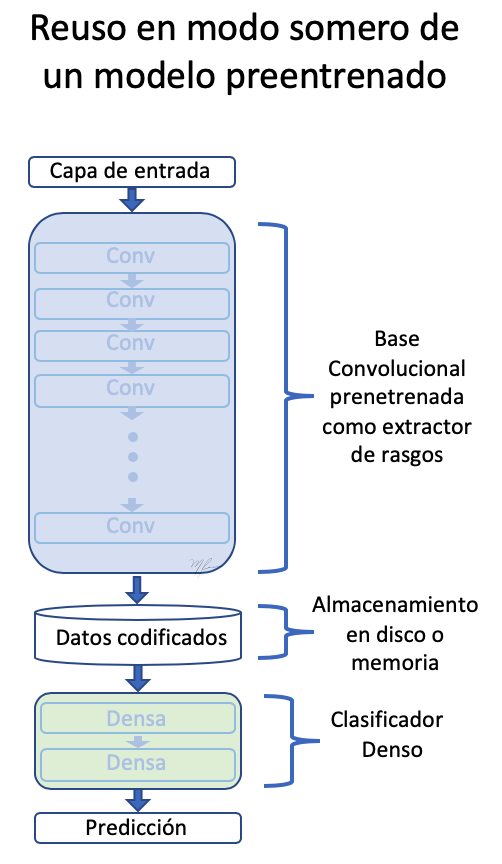

Para generar la codificación (encaje o *embedding*) de las imágenes de perros y gatos usaremos un generador

**Es importante si usamos VGG16 preprocesar los datos (imágenes) para normalizarlas con el mismo procedimiento que se uso para entrenar la red original. En este caso, no es reescalarlas al intervalo $[0,1]$, sino restar la media de cada canal de color**

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip
import os
import zipfile

local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()    

In [ ]:
import os
import numpy as np
from tqdm import tqdm
from keras.applications.imagenet_utils import preprocess_input
#from tqdm import tqdm_notebook as tqdm


from keras.preprocessing.image import ImageDataGenerator

base_dir = '/tmp/cats_and_dogs_filtered'
#base_dir = '/home/mariano/Documents/deep/kaggle/dogs_vs_cats_small'

train_dir      = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir       = os.path.join(base_dir, 'validation')


datagen = ImageDataGenerator(#rescale=1./255)
                             preprocessing_function=preprocess_input)
batch_size = 20

def extract_features(directory, sample_count):
    '''
    Codificador de imagenes mediante conv_base en rasgos para
    posteriormente usarlos como datos para una red clasificadora densa
    
    parámetros
    directory      directorio con con los subdirectorios que definen clases
    sample_count   número de muestras a generar
    
    resultados
    conjunto de características y  etiquetas  
    '''
    # memoria para tensores con datos y etiquetas
    features  = np.zeros(shape=(sample_count, 4, 4, 512))
    labels    = np.zeros(shape=(sample_count))
    # instanciación del generador a partir del directorio donde estan las clases
    generator = datagen.flow_from_directory(directory,
                                            target_size = (150, 150),
                                            batch_size  = batch_size,
                                            class_mode  = 'binary')
    
    rango = list(range(int(sample_count/batch_size)))
    i = 0
    with tqdm(total=len(rango)) as pbar:
        for inputs_batch, labels_batch in tqdm(generator):
            # características predichas (codificadas) por la subred base
            # para las imágenes generadas (aumentadas) en lote
            features_batch = conv_base.predict(inputs_batch)
            # datos y etiquetas
            features[i * batch_size : (i + 1) * batch_size] = features_batch
            labels  [i * batch_size : (i + 1) * batch_size] = labels_batch
            i += 1 
            if i * batch_size >= sample_count:
                # La ejecucion del generador debe terminarse explícitamente después 
                # usar todas la imágenes
                break
            pbar.update(1)
    
    return features, labels

Conjunto de datos-rasgos para entrenamiento, validación y prueba

In [ ]:
train_features, train_labels           = extract_features(train_dir,      2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels             = extract_features(test_dir,       1000)

In [ ]:
generatorInfo = datagen.flow_from_directory(train_dir,
                                            target_size = (150, 150),
                                            batch_size  = 32,
                                            class_mode  = 'binary')

print('Generador            : ',generatorInfo.image_data_generator)
print('Directorio con datos : ',generatorInfo.directory)
print('Clases               : ',generatorInfo.class_indices)
print('Forma de cada imagen : ',generatorInfo.image_shape)

La salida de conv_base tienen la forma ``(samples, 4, 4, 512)``.

Que será la entrada a la red con capas densas, por lo que debe ser aplanada (Flattened) a ``(samples, 8192)``.

In [ ]:
train_features      = np.reshape(train_features,      (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features       = np.reshape(test_features,       (1000, 4 * 4 * 512))

model = None

##Red Clasificadora Densa

Clasifica las imágenes usando sus características extraidas ``conv_base``

In [ ]:
if model != None:
    model.reset_states()    

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

import time
tstart = time.time()

history = model.fit(train_features, train_labels,
                    epochs          = 30,
                    batch_size      = 20,
                    validation_data = (validation_features, validation_labels),
                    verbose         = 2)

print('seconds=', time.time()-tstart)

El entrenamiento es muy rápido dado que la red clasificadora consta únicamente de dos capas ``Dense``.

las curvas del valor función objetivo y la exactitud (``accuracy``) se muestran a continuación.

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

La **validación alcanza los 90%** de exactitud, mucho mejor que el modelo entrenado con aumentación de datos y la BD paqueña que alcanzó un 86%.

La curva de la exactitud ilustra que muy pronto se empieza a tener un sobreajuste (overfitting). Se debe a que no usamos aumentación.

Para implementar aumentación debemos hacer que la extracción de rasgos se haga a la vez que clasificamos, como un modelo completo. Pues en memoria o disco sería impráctico almacenar los datos aumentados para su posterior clasificación. Esto lo explicamos a continuación.

##Transferencia de Conocimiento de Redes Preentrenadas a Nuevos Problemas
**El modelo conv_base como capa de extracción de resgos**

Si asumimos que etapa Convolucional de la VGG16 extrae caractéristicas generales, será esa la parte que podamos reusar. Las características extraidas deberán ser pasadas a un nuevo clasificador binario que debemos implementar y entrenar ex-profeso. Este proceso se mustra en la siguiente figura



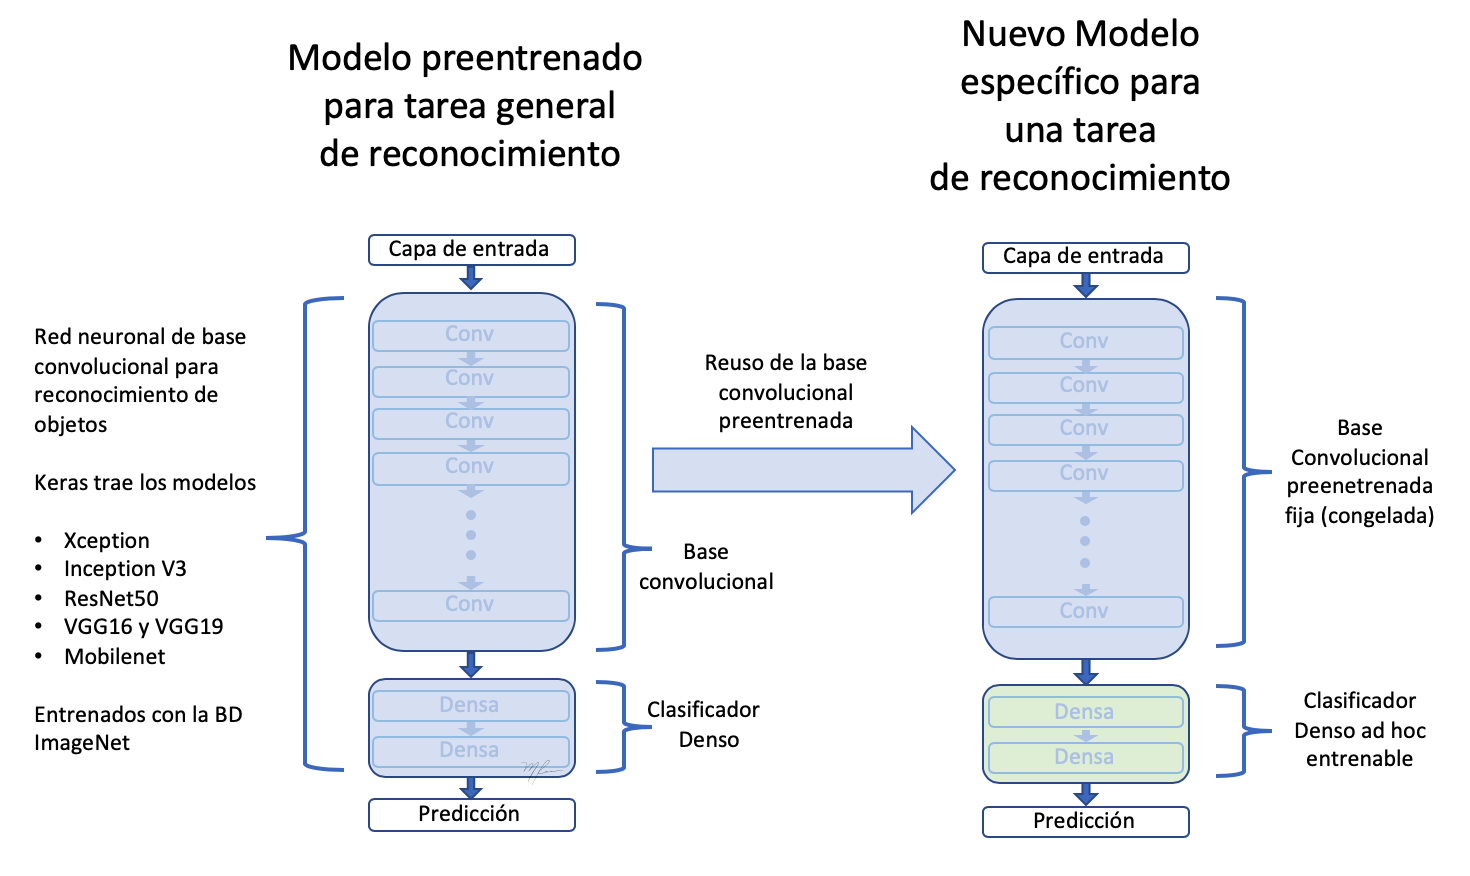

Como la figura ilustra,

1. Reusamos solo la etapa convolucional de la red.

2. Definimos una nueva etapa de clasificación acorde a nuestro problema.

3. Dado que tenemos, relativamente, pocos datos de entrenamiento, fijamos la subred de extracción de rasgos (congelamos sus pesos) para evitar que sean modificados en el entrenamiento.

4. Entrenamos los pesos “entrenables”, los de la etapa de clasificación haciendolos pasar nuestro datos por toda la red.

Usaremos los generadores de datos para hacer un entrenamiento con generadores (fit_generator), como en el ejemplo de la sección anterior.

En Keras todo son capas (layers), por lo que usaremos el modelo conv_base como la primera capa de la red, una capa que calcula rasgos.

Luego añadimos al nuevo modelo secuencial capas clasificadoras densas.

Esta técnica aunque simple de implementar hara que cada imagen aumentada sea pasada por la red conv_base y luego por la clasificadora. Esto hace que los calculos sean ahora mas costosos y no es posible realizarlos en CPU, requerimos de una GPU.

In [ ]:
model.reset_states()

In [ ]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)        # modelo base agradado como una capa!
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.3))  # a ver
model.add(layers.Dense(1, activation='sigmoid'))

Así luce el modelo actualmente:

In [ ]:
#model.summary()

resumen(model)

La red **convolucional base VGG16 htienen casi 15 millones de parámetros, lo que es muy grande. El clasificador en el tope añade otros 2 millones** de parámetetros.

Antes de entrenar “congelaremos” la red extracción de rasgos dado que contamos con pocos datos y queremos aprovechar “el conocimiento” almacenado en la subred base de VGG16 que fue entrenada con muchas clases y debe ser un extractor muy general de características.

Esto lo logramos marcando los pesos de “la capa” ``conv_base`` como no-entrenable:

In [ ]:
print('Número de pesos (matrices) entrenables antes de congelar conv_base : ', len(model.trainable_weights))


In [ ]:
conv_base.trainable = False

In [ ]:
print('Número de pesos (matrices) entrenables después de congelar conv_base : ', len(model.trainable_weights))


In [ ]:
summary(model)

El número de matrices sobrepasa las capas porque cada capa puede tener una matriz de pesos $w$ y un vector de bias $b$.

Para hacer que se congelen los datos necesitamos compilar el modelo y definimos luego los parametros para el generador.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras import models
from keras import layers
from keras import optimizers

train_datagen = ImageDataGenerator(#rescale           = 1./255,
                                   preprocessing_function=preprocess_input,
                                   rotation_range    = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range= 0.2,
                                   shear_range       = 0.2,
                                   zoom_range        = 0.2,
                                   horizontal_flip   = True,
                                   fill_mode         = 'constant',  #'nearest')
                                   cval              = 0)

# La validación no se aumenta!
test_datagen = ImageDataGenerator(#rescale=1./255)
                                    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
                        train_dir,                # directorio con datos de entrenamiento
                        target_size= (150, 150),  # tamaño de la imágenes 
                        batch_size = 20,   
                        shuffle    = True,
                        class_mode = 'binary')    # para clasificación binaria

validation_generator = test_datagen.flow_from_directory(
                        validation_dir,
                        target_size=(150, 150),
                        batch_size=20,
                        class_mode='binary')

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.Nadam(lr=2e-5), #optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

#model.reset_states()

import time
tstart = time.time()

history = model.fit_generator(train_generator,
                              steps_per_epoch = 100, 
                              epochs          = 30,
                              validation_data = validation_generator,
                              validation_steps= 50,
                              verbose         = 2)

print('seconds=', time.time()-tstart)

In [ ]:
model.save('cats_and_dogs_small_3.h5')

Graficamos de nuevo el comportamiento de las métricas registradas durante el entrenamiento

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()


De acuerdo al autor del libro (Chollet), se alcanza una exactitud de cercana al 96.5%.

## Ajuste fino

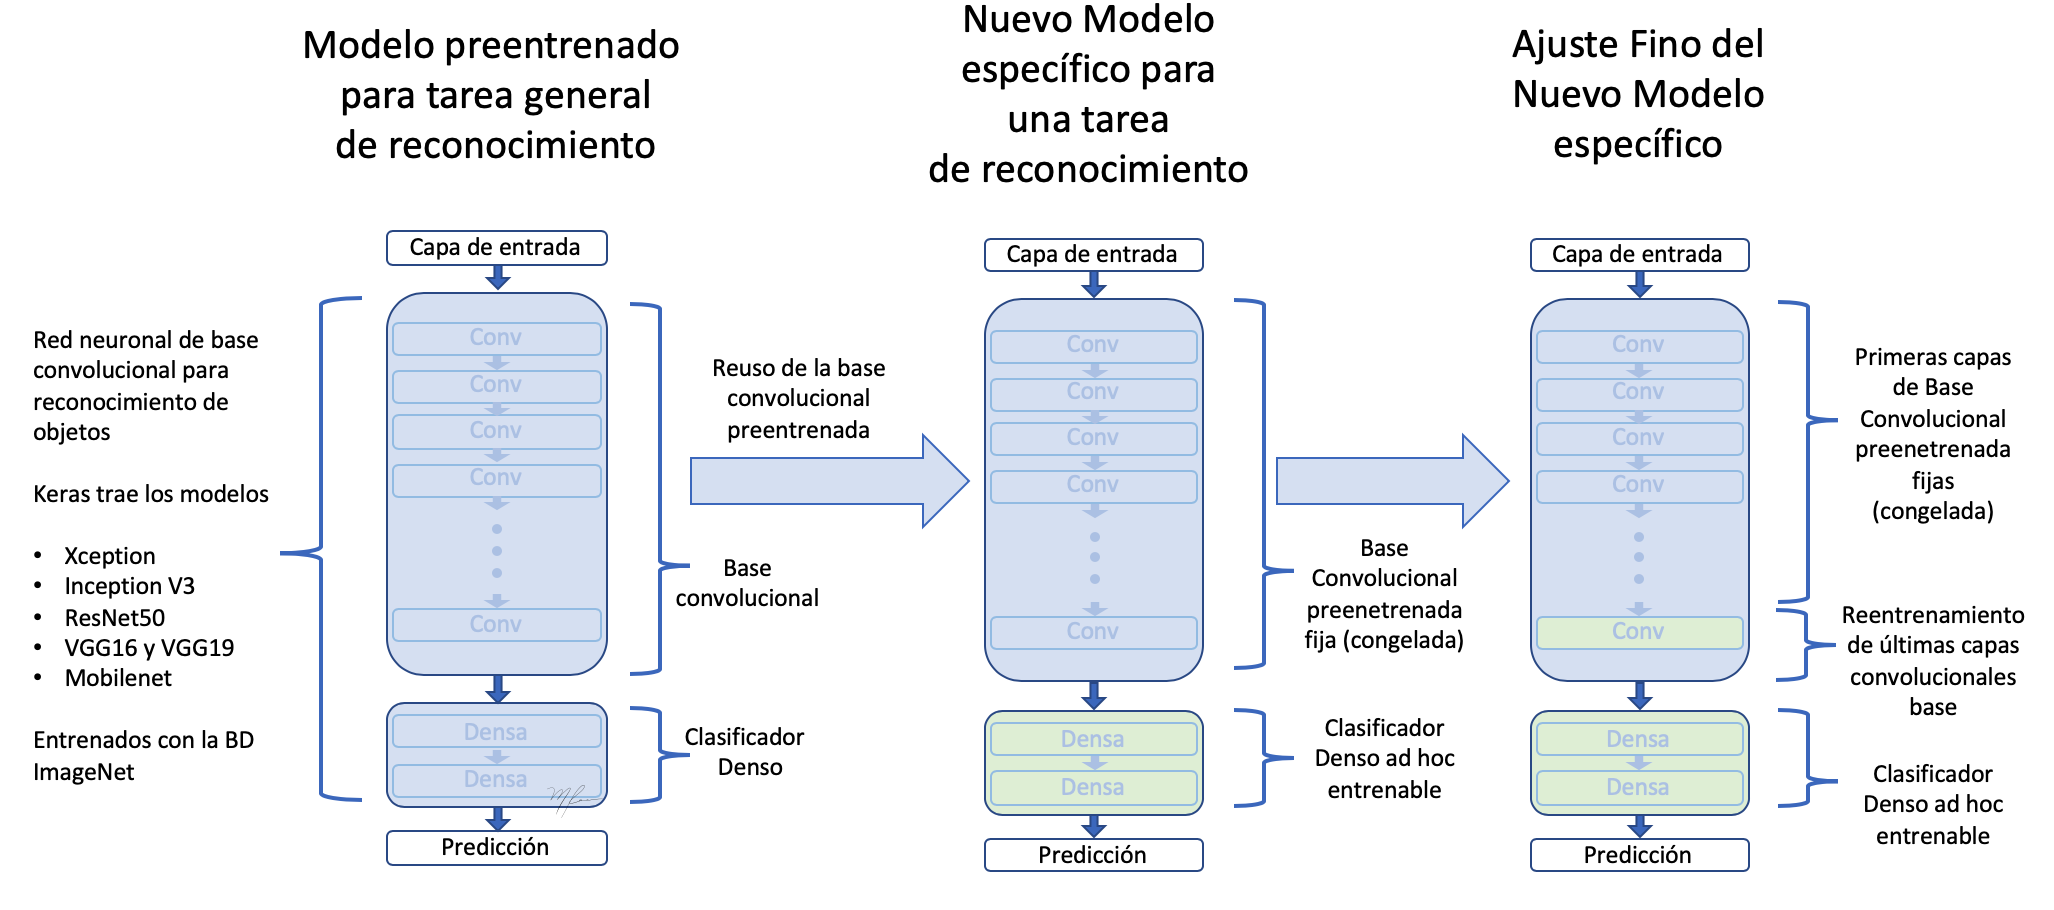

Otra estrategia ampliamente usada en reuso de conocimeinto es el Ajuste Fino (fine-tuning), el cual consite en que, una vez entrenada una capa clasificadora con base prenetrenada, descongelar las últimas capas de la base convolucional para permitir que sus pesos se adapten mejor a la capa clasificadora. Logrando una mejor integración entre la base (entrenada para un problema diferente) y la clasificación.

Los pasos del entrenamiento fino son:

1. Añadir a un base convolucional general una etapa final de clasificación.
1. Congelar la base convolucional.
1. Entrenar la etapa clasificadora.
1. Descongelar las últimas capas de la base convolucional.
1. Entrenar etapa clasificadora y últimas capas de la convolucional juntas.
1. Partiedo del modelo anterio entrenado (pasos 1,2,y 3) vemos que las capas a descongelar son las correspondientes al bloque5.

Como recordatorio el resumen de la convolucional es

In [ ]:
resumen(conv_base)

Haremos el ajuste fino sobre las últimas tres capas convolucionales: ``block5_conv1``, ``block5_conv2`` y ``block5_conv3``.

Es importante notar que las capas mas tempranas codifican información mas general por lo que no es conveniente renetrenarlas si el propósito es reusar conocimiento. Terminaríamos sobreentrenando el modelo a nustras BD pequeña.

In [ ]:
# Orden de las capas 
for layer in conv_base.layers:
    print(layer.name)

In [ ]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
        layer.trainable = True
    else:
        layer.trainable = False
        
resumen(conv_base)   

Note ahora que la ``conv_base`` tienen paramteros entrenables y no entrenables.

Para el entrenamiento fino procedemos a compilar el modelo con un tamaño de paso pequeño para evitar cambios grandes en los pesos, ya que asumimos estra cerca del óptimo y el ajuste no debe ser muy grande

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

In [ ]:
model.save('cats_and_dogs_small_4.h5')

##Gráficas de las métricas registradas durante el entrenamiento

In [ ]:
import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Entrenamiento acc')
plt.plot(epochs, val_acc, 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Entrenamiento loss')
plt.plot(epochs, val_loss, 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

Dado que las curvas son muy ruidosas, es posible filtrarlas para apreciar mejor la tendencia mediante un filtro pasa baja, uno podria intentar

$$\tilde s_i = \sum_{k=0}^n w_k s_{i-k}$$
donde $w$ son un pesos con $\sum_k w_k =1$; 

pero requeririamos usar un filtro bastante ancho (nn grande) para eliminar ruido apropiadamente, en vez de ello tratemos la versión recursiva (como en el libro en que se basa estas notas)

$$\tilde s_i = \alpha \tilde s_{i-1} + (1-\alpha) s_i$$

Que usa el dato recien actualizado con un procedimiento similares. Estos filtros recursivos pueden expresarse como no recursivos (sustituyendo recursivamente el dato actualizado por su fórmula). La ventaja de la forma recursiva es lo compacto de se expresión de actualización

In [ ]:
def smooth_curve(points, factor=0.8):
  smoothed_points = []
  for point in points:
    if smoothed_points:
      previous = smoothed_points[-1]
      smoothed_points.append(previous * factor + point * (1 - factor))
    else:
      smoothed_points.append(point)
  return smoothed_points


import matplotlib.pyplot as plt

acc      = history.history['acc']
val_acc  = history.history['val_acc']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
alpha = 0.9

plt.plot(epochs, smooth_curve(acc,     alpha), 'bo', label='Entrenamiento acc')
plt.plot(epochs, smooth_curve(val_acc, alpha), 'b', label='Validación acc')
plt.title('Accuracy - exactitud de entrenamiento y validación')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss,    alpha), 'bo', label='Entrenamiento loss')
plt.plot(epochs, smooth_curve(val_loss,alpha), 'b', label='Validación loss')
plt.title('Loss - función objetivo en entrenamiento y prueba')
plt.legend()

plt.show()

En estas curvas se puede apreciar mejor la tendencia, podemos notar que se tuvo una mejora de alrededor del 1%.

En (Chollet, 2018) se hace la observación de que la exactitud esta mejorando aun cuando la pérdida no lo hace. Esto se debe a que la pérdida se evalúa mediante un proceso de suma de errores en el vector de salida, algo como:

$$\sum_{i \in epoch} \| y_i - \hat y_i \|_M$$

donde asumimos que $y$ esta en una codificación one-hot y $M$ indica alguna métrica. En cambio, la exactitud se calcula mediante una suma errores de clasificación:

$$\sum_{i \in epoch} 1-\delta (\arg \max_i y_i - \arg \max_i {\hat y_i})$$

Ahora evaluemos, finalmente y por única vez, el conjunto de prueba:

In [ ]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

*Muy cercano al 97%

En la competencia original de Kaggle, estaría entre los mejores (top) resultados, y eso que sólo usamos 2000 datos de entrenamiento vs. 20,000 en la competencia de Kaggle.

## Resumen
* Las redes convolucionales son el mejor modelo de redes neuronales para tratar con problemas de procesamiento de imágenes y visión por computadora.

* La aumentación de datos permite evitar sobreajuste en base de datos pequeñas e incrementrar con datos sintéticas el tamaño de la muestra de entrenamiento

* Es posible usar modelos preentrenados en la etapa de extracción de características para lidiar con bases de datos pequeñas.

* El ajuste fino permite mejorar la interconección de la etapa preentrenada con la etapa clasificadora, mejorando el desempeño general a un bajo costo computacional.

